In [186]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import pearsonr
from tensorflow.keras.models import load_model


In [187]:
# Set working directory
os.chdir('C:/Users/filot/OneDrive - University of Strathclyde/Diss')

In [188]:
forecast_steps = 24

In [189]:
input_steps = 3
run_id = forecast_steps

In [190]:

model = load_model(f'results/model_B/saved_model/{run_id}_model.keras')  # or 'saved_model/my_model'

### STEP 1: Load and preprocess CMEMS wave data

In [191]:
# Process data for period of interest over 6 years

# Set working directory
os.chdir('C:/Users/filot/OneDrive - University of Strathclyde/Diss')
ds = xr.open_dataset("data/part9.nc")

# Extract Hmax
hs = ds['VCMX']  # (time, lat, lon)

# Select the last 17472 time steps
hs_trimmed = hs.isel(time=slice(-17472, None))

print(hs_trimmed.shape)
first_time = hs_trimmed['time'].isel(time=0).values
print(f"The first time step is: {first_time}")

#fill nan with zeros for land data
hs_filled = hs_trimmed.fillna(0)

# Normalize using Z-score normalization or standardization.
mean_hs = hs_filled.mean().values
std_hs = hs_filled.std().values
hs_norm = (hs_filled - mean_hs) / std_hs

# Convert to NumPy (transpose to time, lat, lon)
data = hs_norm.transpose('time', 'latitude', 'longitude').values

print(data.shape)

(17472, 8, 9)
The first time step is: 2019-04-04T00:00:00.000000000
(17472, 8, 9)


### STEP 2: Create sequence-to-one training samples

In [192]:
def create_forecast_at_step_dataset(data, input_steps, forecast_steps, stride=1):
    X, y = [], []
    for t in range(0, len(data) - input_steps - forecast_steps + 1, stride):
        X.append(data[t : t + input_steps])  # 3 past time steps
        y.append(data[t + input_steps + forecast_steps - 1])  # specific future step
    X = np.array(X)[..., np.newaxis]  # Add channel dim
    y = np.array(y)[..., np.newaxis]  # Add channel dim
    return X, y
    
X, y = create_forecast_at_step_dataset(data, input_steps=3, forecast_steps=forecast_steps)
print("X:", X.shape, "y:", y.shape)

X: (17446, 3, 8, 9, 1) y: (17446, 8, 9, 1)


### STEP 3: Split into training and test sets

In [193]:
split = int(len(X) * 0.8)
X_train = X[:split]
y_train = y[:split]

In [194]:
target_times = filtered_time[input_steps + forecast_steps - 1:]  # shape matches y

# Find index in y corresponding to the desired test start date
start_date = np.datetime64('2020-12-01T00:00:00')
start_idx = np.where(target_times >= start_date)[0][0]

# Slice test data
X_test = X[start_idx:]
y_test = y[start_idx:]

# For reference: corresponding time for each forecast
test_time_axis = target_times[start_idx:]

print("Test starts at:", test_time_axis[0])


Test starts at: 2020-12-01T00:00:00.000000000


## Step 4: Evaluating results

### Evaluating model using the test sample

In [195]:
test_loss, test_mae = model.evaluate(X_test, y_test)
print("Test MAE:", test_mae)
print('Test loss:', test_loss)

train_loss, train_mae = model.evaluate(X_train, y_train)
print(f"Training MAE: {train_mae:.4f}")
print(f"Training Loss: {train_loss:.4f}")


91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.9014 - mae: 0.5713
Test MAE: 0.47874611616134644
Test loss: 0.5856691002845764
437/437 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.2591 - mae: 0.3277
Training MAE: 0.3149
Training Loss: 0.2410


In [196]:
# save results in text file
with open(f"results/model_B/metrics_run/metrics_run_{run_id}.txt", "w") as f:
    f.write(f"Forecasting Hour: {run_id}\n")
    f.write(f"Test MAE: {test_mae:.4f}\n")
    f.write(f"Test loss: {test_loss:.4f}\n")
    f.write(f"Train MAE: {train_mae:.4f}\n")
    f.write(f"Train loss: {train_loss:.4f}\n")

In [197]:
# Predict on entire test set
y_pred_test = model.predict(X_test)

# Denormalize
y_pred_test_denorm = y_pred_test * std_hs + mean_hs
y_test_denorm = y_test * std_hs + mean_hs

91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step


### Calculate overall RMSE, SI and R2

In [198]:
# RMSE
overall_rmse = np.sqrt(mean_squared_error(y_test_denorm.flatten(), y_pred_test_denorm.flatten()))

# SI
mean_obs = np.mean(y_test_denorm)
overall_SI = overall_rmse / mean_obs

# R
overall_R, _ = pearsonr(y_test_denorm.flatten(), y_pred_test_denorm.flatten())

print('Overall RMSE:', overall_rmse)
print('Overall SI:', overall_SI)
print('Overall R:', overall_R)

Overall RMSE: 1.6742804
Overall SI: 0.4179263
Overall R: 0.7946382171449913


In [199]:
#save results in text file
with open(f"results/model_B/metrics_run/metrics_run_{run_id}.txt", "a") as f:
    f.write(f"Overall RMSE: {overall_rmse:.4f}\n")
    f.write(f"Overall SI: {overall_SI:.4f}\n")
    f.write(f"Overall R: {overall_R:.4f}\n")

### Evaluate model near Praia do norte

In [200]:
# Get grid indices for lat=-9.1, lon=39.6
lat_idx = np.argmin(np.abs(ds.latitude.values - 39.6))
lon_idx = np.argmin(np.abs(ds.longitude.values - (-9.1)))
print(lat_idx, lon_idx)

4 6


In [201]:
# Extract true and predicted values for this cell, flatten across samples and time
true_vals = y_test_denorm[:, lat_idx, lon_idx, 0].flatten()
pred_vals = y_pred_test_denorm[:, lat_idx, lon_idx, 0].flatten()

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(true_vals, pred_vals))

# SI
mean_obs_point = np.mean(true_vals)
SI = rmse / mean_obs_point

# R
R, _ = pearsonr(true_vals, pred_vals)

print(f"Overall RMSE near Praia do Norte ({lat_idx}, {lon_idx}): {rmse:.4f}")
print(f"Overall SI near Praia do Norte ({lat_idx}, {lon_idx}): {SI:.4f}")
print(f"Overall R near Praia do Norte ({lat_idx}, {lon_idx}): {R:.4f}")

Overall RMSE near Praia do Norte (4, 6): 1.8222
Overall SI near Praia do Norte (4, 6): 0.3861
Overall R near Praia do Norte (4, 6): 0.5706


In [202]:
#save results in text file
with open(f"results/model_B/metrics_run/metrics_run_{run_id}.txt", "a") as f:
    f.write(f"Overall RMSE near Praia do Norte ({lat_idx}, {lon_idx}): {rmse:.4f}\n")
    f.write(f"Overall SI near Praia do Norte ({lat_idx}, {lon_idx}): {SI:.4f}\n")     
    f.write(f"Overall R near Praia do Norte ({lat_idx}, {lon_idx}): {R:.4f}\n")    

### Plot predictions along data

#### Predictions at chosen forecasting point

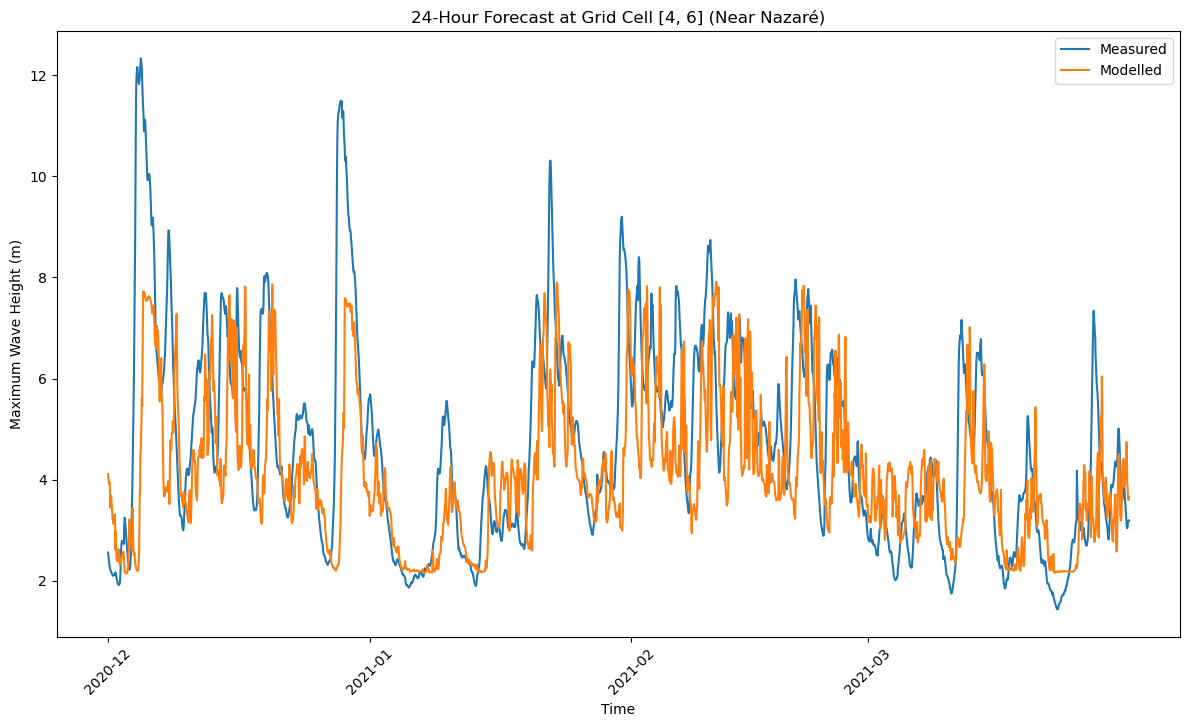

In [203]:
# Extract values at the selected grid point
y_true = y_test_denorm[:, lat_idx, lon_idx, 0]
y_pred = y_pred_test_denorm[:, lat_idx, lon_idx, 0]

# Convert time axis to datetime
time_labels = pd.to_datetime(test_time_axis)

# Get label indices for new month
label_indices = [
    i for i in range(1, len(time_labels))
    if time_labels[i].month != time_labels[i - 1].month
]
label_indices = [0] + label_indices  # Always include first tick
label_strings = [time_labels[i].strftime('%Y-%m') for i in label_indices]

# Plot
plt.figure(figsize=(12, 7))
plt.plot(time_labels, y_true, label='Measured')
plt.plot(time_labels, y_pred, label='Modelled')
plt.xlabel('Time')
plt.ylabel('Maximum Wave Height (m)')
plt.title(f'{forecast_steps}-Hour Forecast at Grid Cell [{lat_idx}, {lon_idx}] (Near Nazaré)')
plt.legend()
plt.grid(False)
plt.tight_layout()

plt.xticks([time_labels[i] for i in label_indices], label_strings, rotation=45)
plt.savefig(f"results/model_A/model_plot/model_plot_{run_id}.png", dpi=300)
plt.show()


### Create Scatter Plot

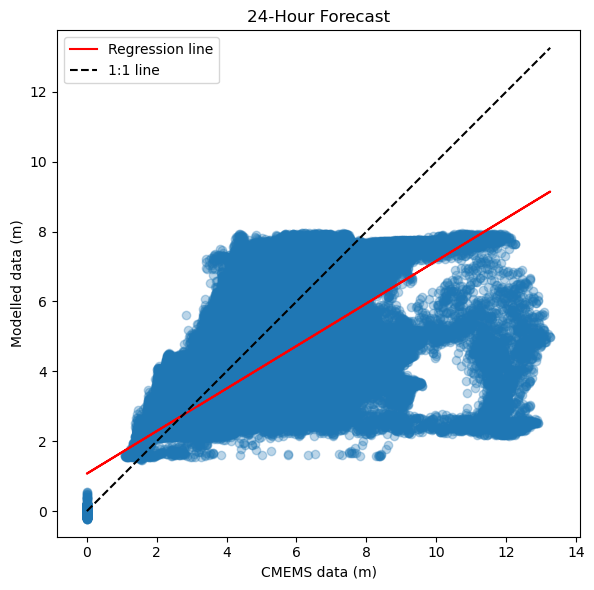

In [204]:
# Flatten predictions and true values
true_vals = y_test_denorm.flatten()
pred_vals = y_pred_test_denorm.flatten()

# Fit regression line
model_fit = LinearRegression()
model_fit.fit(true_vals.reshape(-1, 1), pred_vals)
fitted_line = model_fit.predict(true_vals.reshape(-1, 1))

# Plot
plt.figure(figsize=(6, 6))
#plt.scatter(true_vals, pred_vals, alpha=0.3, label='Predicted vs Measured')
plt.scatter(true_vals, pred_vals, alpha=0.3)
plt.plot(true_vals, fitted_line, color='red', label='Regression line')
plt.plot([true_vals.min(), true_vals.max()], [true_vals.min(), true_vals.max()], 'k--', label='1:1 line')

plt.xlabel('CMEMS data (m)')
plt.ylabel('Modelled data (m)')
plt.title(f'{run_id}-Hour Forecast')
plt.legend(loc='upper left')
plt.grid(False)
plt.axis('equal')
plt.tight_layout()

plt.savefig(f"results/model_B/scatter_plot/scatter_plot_{run_id}.png", dpi=300)
plt.show()
